In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


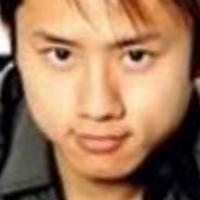

26 0


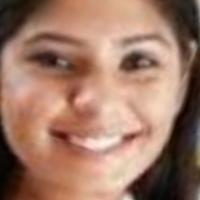

21 1


In [4]:
import os
from PIL import Image
import pandas as pd

images = []
ages = []
genders = []

for i in os.listdir('../input/utkface-new/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))
    genders.append(int(split[1]))
    images.append(Image.open('../input/utkface-new/crop_part1/' + i))

images = pd.Series(list(images), name='Images')
ages = pd.Series(list(ages), name='Ages')
genders = pd.Series(list(genders), name='Genders')

df = pd.concat([images, ages, genders], axis=1)
df

display(df['Images'][0])
print(df['Ages'][0], df['Genders'][0])

display(df['Images'][1])
print(df['Ages'][1], df['Genders'][1])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


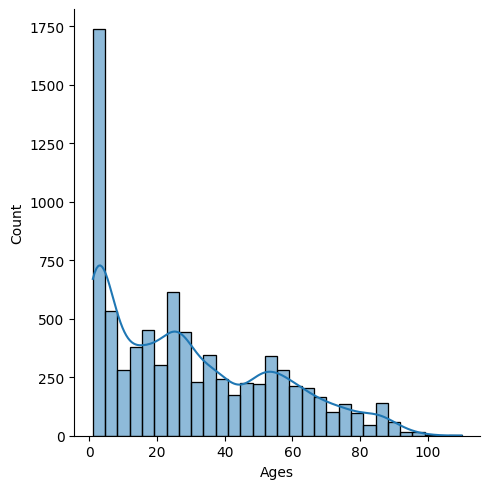

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


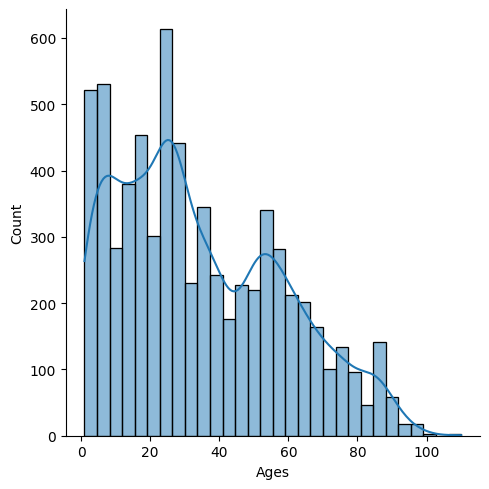

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


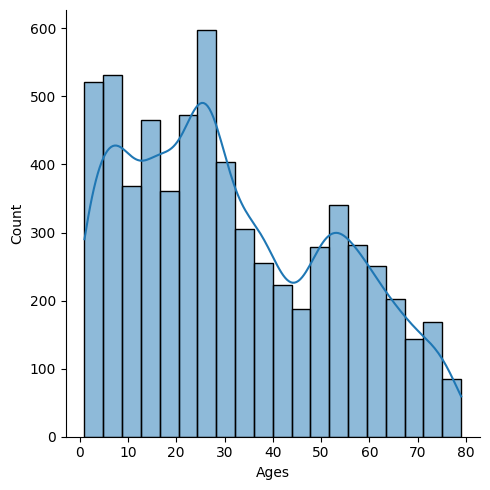

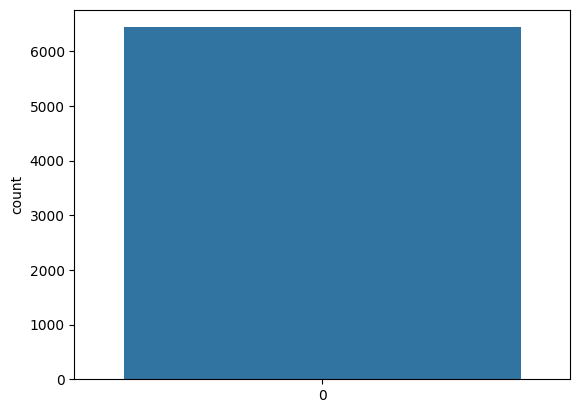

In [5]:
import matplotlib.pyplot as plt


# Plot initial age distribution
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Filter and sample data for ages <= 4
under4s = df[df['Ages'] <= 4].sample(frac=0.3)
df = pd.concat([df[df['Ages'] > 4], under4s], ignore_index=True)

# Plot age distribution after filtering
sns.displot(df['Ages'], kde=True, bins=30)
plt.show()

# Remove ages > 80
df = df[df['Ages'] < 80]

# Plot age distribution after removing ages > 80
sns.displot(df['Ages'], kde=True, bins=20)
plt.show()

# Remove entries with gender = 3
df = df[df['Genders'] != 3]

# Plot gender distribution after filtering gender = 3
sns.countplot(df['Genders'])
plt.show()

# Resize images and prepare data for training
x = []
y = []

for i in range(len(df)):
    resized_image = df['Images'].iloc[i].resize((200, 200), Image.LANCZOS).copy()
    ar = np.asarray(resized_image)
    x.append(ar)
    agegen = [int(df['Ages'].iloc[i]), int(df['Genders'].iloc[i])]
    y.append(agegen)

x = np.array(x)

# Continue with the rest of your code as needed

In [6]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [5]:
from tensorflow.keras import layers

# Age Model
age_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

age_model.add(resnet_model)
age_model.add(GlobalAveragePooling2D())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(64, activation='relu'))
age_model.add(Dropout(0.5))
age_model.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(lr=0.0001),
                  metrics=['accuracy'])

# Gender Model
gender_model = Sequential()
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

gender_model.add(resnet_model)
gender_model.add(GlobalAveragePooling2D())
gender_model.add(Dense(128, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.5))
gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(loss='binary_crossentropy',
                     optimizer=optimizers.Adam(lr=0.0001),
                     metrics=['accuracy'])

94765736/94765736 [==============================] - 1s 0us/step


In [6]:
# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age = age_model.fit(train_age, epochs=5, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender = gender_model.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)



Epoch 1/5
161/161 [==============================] - 95s 297ms/step - loss: 397.5595 - accuracy: 0.0400 - val_loss: 1133.8837 - val_accuracy: 0.0404
Epoch 2/5
161/161 [==============================] - 47s 291ms/step - loss: 273.1980 - accuracy: 0.0396 - val_loss: 616.1177 - val_accuracy: 0.0404
Epoch 3/5
161/161 [==============================] - 46s 287ms/step - loss: 221.7775 - accuracy: 0.0396 - val_loss: 699.4029 - val_accuracy: 0.0404
Epoch 4/5
161/161 [==============================] - 46s 287ms/step - loss: 204.9367 - accuracy: 0.0398 - val_loss: 420.1204 - val_accuracy: 0.0404
Epoch 5/5
161/161 [==============================] - 47s 289ms/step - loss: 193.5016 - accuracy: 0.0400 - val_loss: 304.5284 - val_accuracy: 0.0404
Epoch 1/50
81/81 [==============================] - 88s 580ms/step - loss: 0.6098 - accuracy: 0.7005 - val_loss: 23.5246 - val_accuracy: 0.4387
Epoch 2/50
81/81 [==============================] - 47s 574ms/step - loss: 0.4244 - accuracy: 0.8150 - val_loss: 0.

In [7]:
# Retrieve final accuracy values for Age Model
final_training_accuracy_age = history_age.history.get('accuracy', history_age.history.get('acc'))
final_validation_accuracy_age = history_age.history.get('val_accuracy', history_age.history.get('val_acc'))


# Retrieve final accuracy values for Gender Model
final_training_accuracy_gender = history_gender.history.get('accuracy', history_gender.history.get('acc'))
final_validation_accuracy_gender = history_gender.history.get('val_accuracy', history_gender.history.get('val_acc'))

if final_training_accuracy_gender is not None:
    final_training_accuracy_gender = final_training_accuracy_gender[-1] if isinstance(final_training_accuracy_gender, list) else final_training_accuracy_gender
    print("Resnet50 Model Final Training Accuracy:", final_training_accuracy_gender)
else:
    print("Gender Model Training Accuracy not available.")

if final_validation_accuracy_gender is not None:
    final_validation_accuracy_gender = final_validation_accuracy_gender[-1] if isinstance(final_validation_accuracy_gender, list) else final_validation_accuracy_gender
    print("Resnet50 Model Final Validation Accuracy:", final_validation_accuracy_gender)
else:
    print("Gender Model Validation Accuracy not available.")

Resnet50 Model Final Training Accuracy: 0.9704968929290771
Resnet50 Model Final Validation Accuracy: 0.8951863646507263


In [8]:
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((200,200), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((200,200), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)
    
    age = agemodel.predict(ar)
    gender = np.round(genmodel.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'
        
    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300,300), Image.ANTIALIAS)

1/1 [==============================] - 0s 44ms/step


/tmp/ipykernel_42/3451417546.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((200, 200), Image.ANTIALIAS)


1/1 [==============================] - 0s 35ms/step
Age: 38 
 Gender: male
1/1 [==============================] - 0s 25ms/step
Age: 44 
 Gender: female


/tmp/ipykernel_42/3451417546.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return im.resize((300, 300), Image.ANTIALIAS)


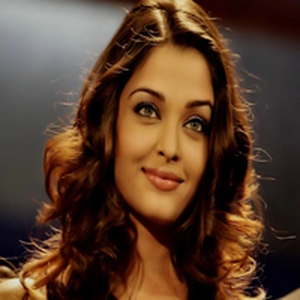

In [13]:
# Process and predict function for ResNet50 models
def process_and_predict_resnet50(file, age_model, gender_model):
    im = Image.open(file)
    im = im.resize((200, 200), Image.ANTIALIAS)
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 200, 200, 3)

    age = age_model.predict(ar)
    gender = np.round(gender_model.predict(ar))
    if gender == 0:
        gender = 'male'
    elif gender == 1:
        gender = 'female'

    print('Age:', int(age), '\n Gender:', gender)
    return im.resize((300, 300), Image.ANTIALIAS)

age_model.save('/kaggle/working/age_model_resnet.h5')
gender_model.save('/kaggle/working/gender_model_resnet.h5') 

# Celebrities prediction with ResNet50 models

process_and_predict_resnet50('../input/celebrity/s3.jpg', age_model, gender_model)
process_and_predict_resnet50('../input/celebrity/s4.jpg', age_model, gender_model)

1/1 [==============================] - 0s 30ms/step


/tmp/ipykernel_42/3451417546.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((200, 200), Image.ANTIALIAS)
/tmp/ipykernel_42/3451417546.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return im.resize((300, 300), Image.ANTIALIAS)


Age: 44 
 Gender: female


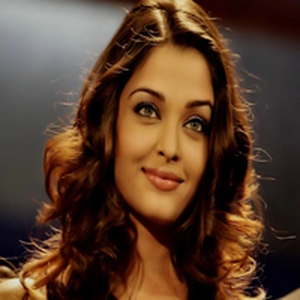

In [10]:
process_and_predict_resnet50('../input/celebrity/s4.jpg', age_model, gender_model)

1/1 [==============================] - 0s 25ms/step
Age: 19 
 Gender: male


/tmp/ipykernel_42/3451417546.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((200, 200), Image.ANTIALIAS)
/tmp/ipykernel_42/3451417546.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  return im.resize((300, 300), Image.ANTIALIAS)


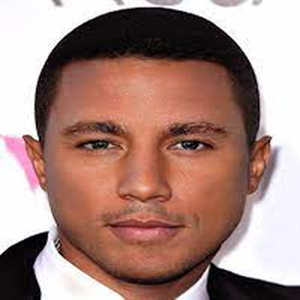

In [11]:
process_and_predict_resnet50('../input/celebrity/s1.jpg', age_model, gender_model)

In [12]:
# import shutil

# shutil.make_archive("/kaggle/working/models", 'zip', "/kaggle/working/")


RuntimeError: File size unexpectedly exceeded ZIP64 limit

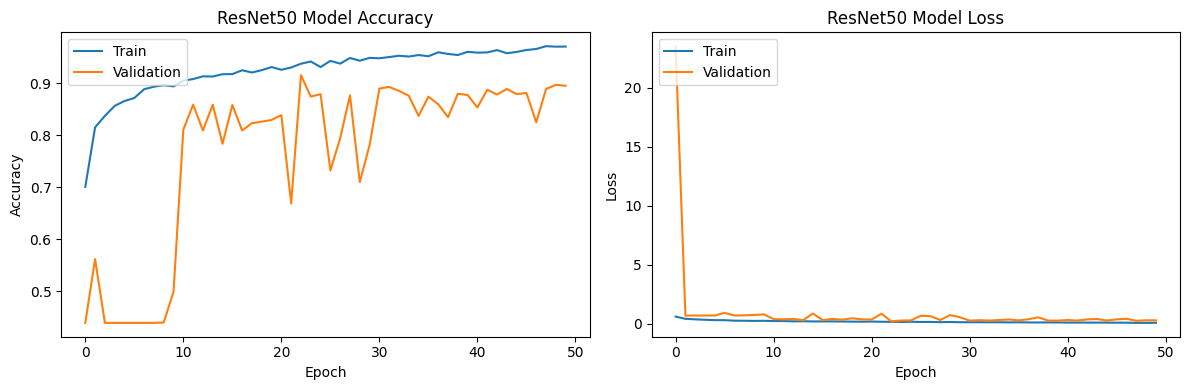

In [14]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()



# Plot ResNet50 Gender Model
plot_history(history_gender, 'ResNet50')

In [8]:
#Inception v3
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split

from keras.applications import InceptionV3
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical



y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [9]:
from tensorflow.keras import layers

# Age Model with InceptionV3
age_model_inception = Sequential()
inception_model_age = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

age_model_inception.add(inception_model_age)
age_model_inception.add(GlobalAveragePooling2D())
age_model_inception.add(Dense(128, activation='relu'))
age_model_inception.add(Dropout(0.5))
age_model_inception.add(Dense(64, activation='relu'))
age_model_inception.add(Dropout(0.5))
age_model_inception.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model_inception.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Gender Model with InceptionV3
gender_model_inception = Sequential()
inception_model_gender = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

gender_model_inception.add(inception_model_gender)
gender_model_inception.add(GlobalAveragePooling2D())
gender_model_inception.add(Dense(128, activation='relu'))
gender_model_inception.add(Dropout(0.5))
gender_model_inception.add(Dense(64, activation='relu'))
gender_model_inception.add(Dropout(0.5))
gender_model_inception.add(Dense(1, activation='sigmoid'))

gender_model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
# Training the Models

# Age Model Training
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age_inception = age_model_inception.fit(train_age, epochs=5, shuffle=True, validation_data=test_age)

# Gender Model Training
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

history_gender_inception = gender_model_inception.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

Epoch 1/5
161/161 [==============================] - 101s 313ms/step - loss: 361.5787 - accuracy: 0.0439 - val_loss: 987.1252 - val_accuracy: 0.0435
Epoch 2/5
161/161 [==============================] - 50s 307ms/step - loss: 236.9845 - accuracy: 0.0439 - val_loss: 195.0251 - val_accuracy: 0.0435
Epoch 3/5
161/161 [==============================] - 49s 305ms/step - loss: 199.7262 - accuracy: 0.0439 - val_loss: 145.4296 - val_accuracy: 0.0435
Epoch 4/5
161/161 [==============================] - 49s 302ms/step - loss: 187.6318 - accuracy: 0.0439 - val_loss: 99.4347 - val_accuracy: 0.0435
Epoch 5/5
161/161 [==============================] - 50s 308ms/step - loss: 164.1170 - accuracy: 0.0439 - val_loss: 166.7039 - val_accuracy: 0.0435
Epoch 1/50
81/81 [==============================] - 92s 600ms/step - loss: 0.5242 - accuracy: 0.7481 - val_loss: 16.9084 - val_accuracy: 0.5613
Epoch 2/50
81/81 [==============================] - 49s 604ms/step - loss: 0.3486 - accuracy: 0.8490 - val_loss: 70.

In [11]:

# Evaluate the Gender Model on the test dataset
test_loss_gender_inception, test_accuracy_gender_inception = gender_model_inception.evaluate(test_gender)
print(f'Test Gender Model Accuracy (Inception): {test_accuracy_gender_inception * 100:.2f}%')

21/21 [==============================] - 1s 63ms/step - loss: 0.4745 - accuracy: 0.8890
Test Gender Model Accuracy (Inception): 88.90%


In [12]:
# Save Age Model
age_model_inception.save('/kaggle/working/age_model_inception.h5')

# Save Gender Model
gender_model_inception.save('/kaggle/working/gender_model_inception.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


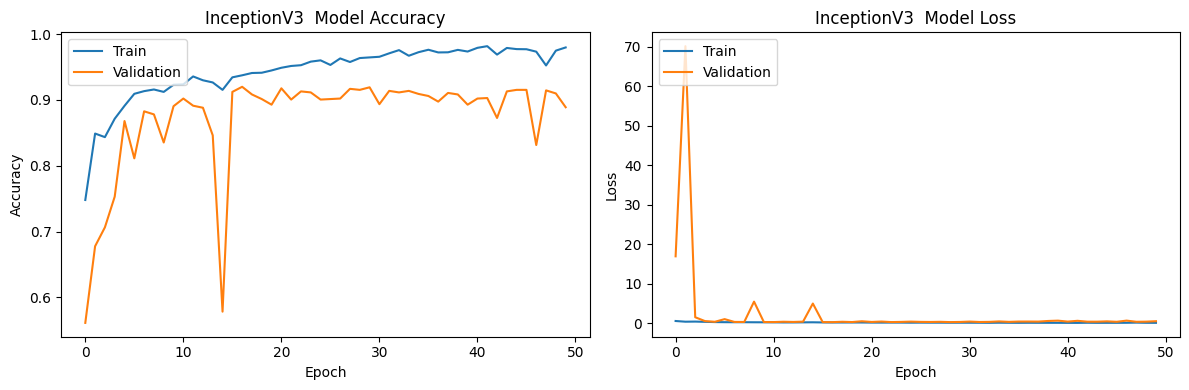

In [13]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()




# Plot InceptionV3 Gender Model
plot_history(history_gender_inception, 'InceptionV3 ')

In [14]:
# Necessary imports
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50, InceptionV3, VGG16
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

In [15]:
from tensorflow.keras import layers

# Age Model with VGG16
age_model_vgg16 = Sequential()
vgg16_model_age = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

age_model_vgg16.add(vgg16_model_age)
age_model_vgg16.add(GlobalAveragePooling2D())
age_model_vgg16.add(Dense(64, activation='relu'))  # Reducing the number of neurons
age_model_vgg16.add(Dropout(0.5))
age_model_vgg16.add(Dense(1, activation='linear'))  # Linear activation for regression

age_model_vgg16.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# Gender Model with VGG16
gender_model_vgg16 = Sequential()
vgg16_model_gender = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

gender_model_vgg16.add(vgg16_model_gender)
gender_model_vgg16.add(GlobalAveragePooling2D())
gender_model_vgg16.add(Dense(64, activation='relu'))  # Reducing the number of neurons
gender_model_vgg16.add(Dropout(0.5))
gender_model_vgg16.add(Dense(1, activation='sigmoid'))

gender_model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
# Training the Models

# Age Model Training using VGG16
datagen_age = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_age = ImageDataGenerator(rescale=1./255)

train_age = datagen_age.flow(x_train_age, y_train_age, batch_size=32)
test_age = test_datagen_age.flow(x_test_age, y_test_age, batch_size=32)

history_age_vgg16 = age_model_vgg16.fit(train_age, epochs=5, shuffle=True, validation_data=test_age)

# Gender Model Training using VGG16
datagen_gender = ImageDataGenerator(
    rescale=1./255., width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen_gender = ImageDataGenerator(rescale=1./255)

train_gender = datagen_gender.flow(x_train_gender, y_train_gender, batch_size=64)
test_gender = test_datagen_gender.flow(x_test_gender, y_test_gender, batch_size=64)

Epoch 1/5
161/161 [==============================] - 61s 311ms/step - loss: 722.0545 - accuracy: 0.0435 - val_loss: 470.1028 - val_accuracy: 0.0435
Epoch 2/5
161/161 [==============================] - 49s 305ms/step - loss: 522.8746 - accuracy: 0.0439 - val_loss: 443.6229 - val_accuracy: 0.0435
Epoch 3/5
161/161 [==============================] - 50s 309ms/step - loss: 509.9124 - accuracy: 0.0439 - val_loss: 453.0798 - val_accuracy: 0.0435
Epoch 4/5
161/161 [==============================] - 51s 316ms/step - loss: 498.5591 - accuracy: 0.0439 - val_loss: 450.8075 - val_accuracy: 0.0435
Epoch 5/5
161/161 [==============================] - 50s 309ms/step - loss: 508.9769 - accuracy: 0.0439 - val_loss: 456.3970 - val_accuracy: 0.0435


In [17]:
history_gender_vgg16 = gender_model_vgg16.fit(train_gender, epochs=50, shuffle=True, validation_data=test_gender)

# Evaluate the Age Model on the test dataset using VGG16
test_loss_age_vgg16, test_accuracy_age_vgg16 = age_model_vgg16.evaluate(test_age)
print(f'Test Age Model Accuracy (VGG16): {test_accuracy_age_vgg16 * 100:.2f}%')

# Evaluate the Gender Model on the test dataset using VGG16
test_loss_gender_vgg16, test_accuracy_gender_vgg16 = gender_model_vgg16.evaluate(test_gender)
print(f'Test  Model Accuracy (VGG16): {test_accuracy_gender_vgg16 * 100:.2f}%')

Epoch 1/50
81/81 [==============================] - 63s 599ms/step - loss: 0.7345 - accuracy: 0.5423 - val_loss: 0.7886 - val_accuracy: 0.5613
Epoch 2/50
81/81 [==============================] - 48s 593ms/step - loss: 0.7068 - accuracy: 0.5256 - val_loss: 0.6898 - val_accuracy: 0.5613
Epoch 3/50
81/81 [==============================] - 49s 598ms/step - loss: 0.6879 - accuracy: 0.5592 - val_loss: 0.6914 - val_accuracy: 0.5613
Epoch 4/50
81/81 [==============================] - 49s 596ms/step - loss: 0.6881 - accuracy: 0.5565 - val_loss: 0.7262 - val_accuracy: 0.5613
Epoch 5/50
81/81 [==============================] - 48s 588ms/step - loss: 0.6870 - accuracy: 0.5609 - val_loss: 0.6848 - val_accuracy: 0.5613
Epoch 6/50
81/81 [==============================] - 48s 589ms/step - loss: 0.6864 - accuracy: 0.5613 - val_loss: 0.6826 - val_accuracy: 0.5613
Epoch 7/50
81/81 [==============================] - 49s 602ms/step - loss: 0.6867 - accuracy: 0.5611 - val_loss: 0.7025 - val_accuracy: 0.5613

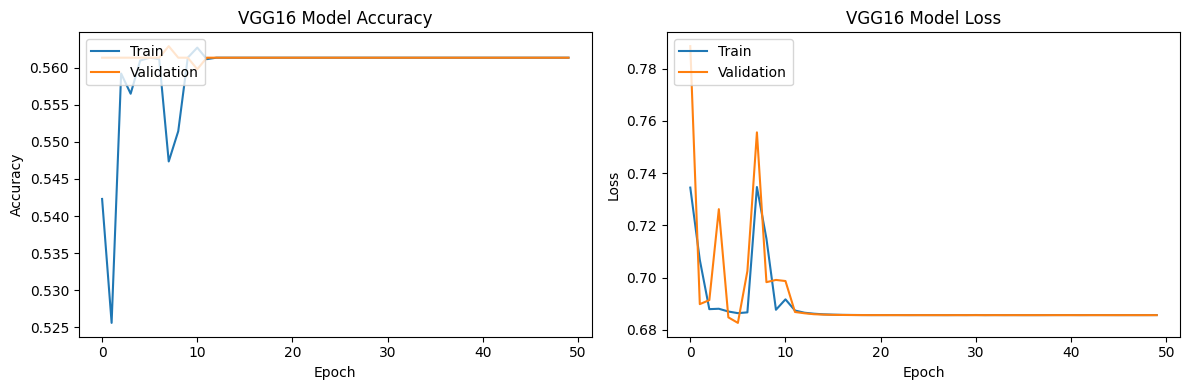

In [18]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss
def plot_history(history, model_name):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()





# Plot VGG16 Gender Model
plot_history(history_gender_vgg16, 'VGG16')


In [20]:
# Save Age Model
age_model_vgg16.save('/kaggle/working/age_model_vgg.h5')

# Save Gender Model
gender_model_vgg16.save('/kaggle/working/gender_model_vgg.h5')
